Neuroimaging cartesian reconstruction: Benchmarking between Undecimated and Decimated Wavelet Transform
=====================================
Author: Chaithya G R

In this tutorial we will reconstruct an MRI image from the sparse kspace
measurements.

Import neuroimaging data
------------------------
We use the toy datasets available in pysap, more specifically a 2D brain slice
and the cartesian acquisition scheme.

In [1]:
# Package import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
from mri.operators import FFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
from pysap.data import get_sample_data
import pysap

# Third party import
import numpy as np
import matplotlib.pyplot as plt

Loading input data and K-Space Cartesian Mask

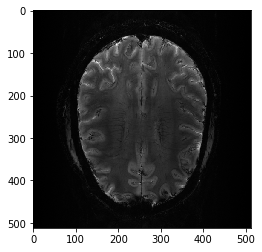

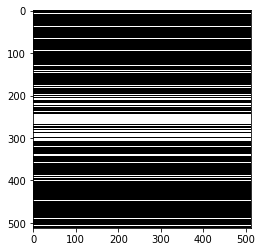

In [2]:
image = get_sample_data('2d-mri')
mask = get_sample_data("cartesian-mri-mask")
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------
From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [3]:
kspace_loc = convert_mask_to_locations(mask.data)
fourier_op = FFT(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)

/home/chaithyagr/Codes/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


Reconstruction 1 : Decimated Wavelet
------------------------------

Linear Operator : Symlet8 with 4 Scales
Regularizer Operator : SparseThreshold ie L1 Norm, lambda = 2e-7 

100% (100 of 100) |######################| Elapsed Time: 0:00:22 Time:  0:00:22


Lipschitz constant is 1.1000000000000545
The lipschitz constraint is satisfied
 - mu:  2e-07
 - lipschitz constant:  1.1000000000000545
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7fafbd2c8160> - 4
 - max iterations:  100
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...
 - final iteration number:  100
 - final log10 cost value:  -7.835120865857485
 - converged:  True
Done.
Execution time:  42.823034  seconds
----------------------------------------


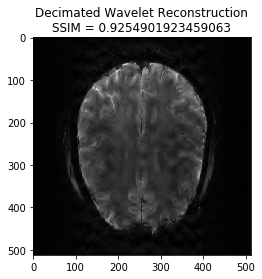

In [4]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")

reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='fista',
    num_iterations=100,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Decimated Wavelet Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

Reconstruction 2 : Undecimated Wavelet
------------------------------

Linear Operator : Undecimated (bi-) orthogonal transform (three bands per scale) with 4 scales
Regularizer Operator : SparseThreshold ie L1 Norm, lambda = 2e-7 

100% (100 of 100) |######################| Elapsed Time: 0:02:17 Time:  0:02:17


Lipschitz constant is 1.1000000000000008
The lipschitz constraint is satisfied
 - mu:  1.33e-07
 - lipschitz constant:  1.1000000000000008
 - tau:  0.9374654926116561
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7fafbd119320> - 4
 - max iterations:  100
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...
 - final iteration number:  100
 - final cost value:  1.0310405004168508e-07
 - converged:  True
Done.
Execution time:  168.481276  seconds
----------------------------------------


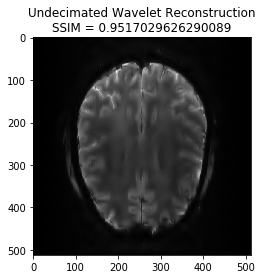

In [5]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
regularizer_op = SparseThreshold(linear_op, 1.33 * 1e-7, thresh_type="soft")
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='condatvu',
    num_iterations=100,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Undecimated Wavelet Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()